In [1]:
from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
print(os.getcwd())
os.chdir('/content/drive/MyDrive/21fa_cs492i/projects/src')
print(os.getcwd())

/content
/content/drive/MyDrive/21fa_cs492i/projects/src


In [3]:
import os
import os.path as osp
import sys
from glob import glob

import datetime
import time
import pytz

import pandas as pd
import numpy as np
from tqdm import tqdm

import sklearn

import torch
import torchvision
# from torchinfo import summary

import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import torchvision.models as models

!pip install explain
import explain

import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable



     |████████████████████████████████| 57 kB 3.0 MB/s 
  Created wheel for explain: filename=explain-0.1.1-py3-none-any.whl size=2638 sha256=b237d1a6908f90baadad3f53cab95ce30ac9f75b797f30a8e0a157ee7a8f4966
  Stored in directory: /root/.cache/pip/wheels/5c/78/f0/c31eacc637c80b4eeee46348a804f46b2dc37dc242793fa89a
  Created wheel for sh: filename=sh-1.9-py3-none-any.whl size=19693 sha256=6c8f65990eb09e786d46fb75a89cfa9b7297909b6ac4546da66f7858e3d7052d
  Stored in directory: /root/.cache/pip/wheels/41/ab/45/b9eb2c547c2c9f603022d2c9d759941a0486b92ae91dd11142
Successfully built explain sh
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pip-tools 6.2.0 requires click>=7, but you have click 3.1 which is incompatible.
flask

## 모델 파라미터 (Parameter)

In [4]:
# 모델에 입력할 Input 이미지의 크기를 지정함.
IMG_WIDTH = 256
IMG_HEIGHT = 256

# 배치 사이즈 임의 지정
batch_size = 128

# 데이터를 읽어올 경로를 지정함.
data_dir='/content/drive/MyDrive/21fa_cs492i/projects/dataset/'
# 학습된 모델이 저장된 경로를 지정함.
ckpt_dir = '/content/drive/MyDrive/21fa_cs492i/projects/model_weight/'

# 모델 이름
# Model_name = 'resnext50_32x4d_vgg19_best_Acc'
# 모델을 연산할 장비 설정 (Docker환경에서 작동할 수 있도록 CPU에서 계산함)
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train, Validation, Test 데이터 셋 확인

In [ ]:
# label=['1++','1+','1','2','3']

# for set_ in ['train','val','test']:
#     set_size=len(glob(osp.join(data_dir, set_, '*', '*'), recursive=True))
#     if set_=='val':
#         print(f"{set_+'idation'} set size: {set_size}\n")
#     else:
#         print(f"{set_} set size: {set_size}\n")
    
#     for i in range(5):
#         size=len(glob(osp.join(data_dir, set_, str(i), '*'), recursive=True))
#         print(f"The number of Class {label[i]}: {size} / {set_size} = {size/set_size :.2f}")
#     print('-'*45)
#     print()

## 데이터 셋 (Dataset) 불러오기

In [5]:
# 이미지 transformation
test_compose=transforms.Compose([
    transforms.Resize((IMG_HEIGHT,IMG_WIDTH)),
    transforms.ToTensor()
])

# Test set을 읽어옴
test_dataset=datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_compose)
test_dataloader=DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

### 모델 불러오기 (Load)

In [ ]:
# Model: ResNeXt50_32x4d
# model=models.resnet50(pretrained=False)
# model = models.mobilenet_v3_small(pretrained=False)
# 최종 Label 의 개수 = 5 (1++, 1+, 1, 2, 3)
# model.fc=nn.Linear(model.fc.in_features, 5)

# model_names= sorted(name for name in models.__dict__
#                    if name.islower() and not name.startswith("__")
#                     and callable(models.__dict__[name]))
model_names = ['vgg19', 'resnext50_32x4d', 'mobilenet_v3_small']
ckpt_names = ['vgg19_trial_1_best_Acc', 'resnext50_32x4d_trial1_best_Acc',
              'mobilenet_v3_small_trial_1_best_Acc', 'mobilenet_v3_small_transfer_best_Acc']
# 0 for vgg
# 1 for resnext50
# 2 for mobilenet
model_name = model_names[0] # choose vgg
ckpt_name = ckpt_names[0]

model=models.__dict__[model_name](pretrained=False)

if 'res' in str(model_name):
        model.fc=nn.Linear(model.fc.in_features, 5)
    
elif 'vgg' in str(model_name):
    model.classifier[-4]=nn.Linear(in_features=4096, out_features=256)
    model.classifier[-1]=nn.Linear(in_features=256, out_features=5)

elif 'mobilenet' in str(model_name):
    model.classifier[0] = nn.Linear(in_features=model.classifier[0].in_features, out_features=256)
    model.classifier[3] = nn.Linear(in_features=256, out_features=5)

# 학습된 모델 가중치 불러오기
checkpoint=torch.load(ckpt_dir + ckpt_name + '.pth', map_location=device)
model.load_state_dict(checkpoint['state_dict'])

now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 시작 시간 : {nowDatetime}')

since=time.time()

tot_labels=[]  # 전체 정답 Label 을 저장할 리스트
tot_pred_labels=[]  # 전체 예측 Label 을 저장할 리스트

# 모델을 device에 올림
model=model.to(device)
# 네트워크를 evaluation 용으로 선언
model=model.eval()

# test 이기 때문에 backprop 진행 x
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):

        images=images.to(device)
        labels=labels.to(device)

        # Model Prediction (forward)
        output=model(images).detach().cpu()
        _, output_index = torch.max(output, 1)    

        tot_labels.extend(list(labels.detach().cpu().numpy()))
        tot_pred_labels.extend(list(output_index.view(-1).numpy()))

end=time.time()
print(f'테스트 소요 시간: {int((end-since)//60)}m {int((end-since)%60)}s')
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 종료 시간 : {nowDatetime}')




Predicted     1    1+   1++    2    3   All
True                                       
1          1067   229   519  107    3  1925
1+          556   730   703   50    2  2041
1++         443   447  1326   12    0  2228
2           331    38   208  523   26  1126
3            13     4    40   96  330   483
All        2410  1448  2796  788  361  7803


#-- Confusion Matrix for class 1

            Pred      
           Non 1     1
True Non 1  4535  1343
     1       858  1067

Accuracy for class 1 : 71.793
-----------------------------------

#-- Confusion Matrix for class 1+

              Pred     
            Non 1+   1+
True Non 1+   5044  718
     1+       1311  730

Accuracy for class 1+ : 73.997
-----------------------------------

#-- Confusion Matrix for class 1++

                Pred      
             Non 1++   1++
True Non 1++    4105  1470
     1++         902  1326

Accuracy for class 1++ : 69.601
-----------------------------------

#-- Confusion Matrix for class 2

    

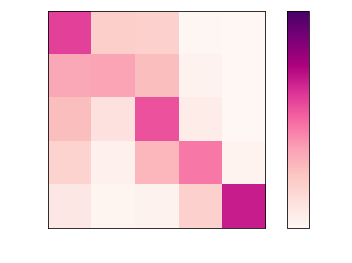

In [35]:
result=explain.ShowResult(tot_labels, tot_pred_labels)
cm_mat = result.show_result()
ticks = np.linspace(0, 1, 11)
# cm = np.array([[1043, 341, 125, 255, 161],
#                 [666, 910, 130, 195, 140],
#                 [712, 536, 624, 173, 183],
#                 [187, 174, 39, 438, 288],
#                 [6, 10, 12, 28, 427]])
cm = cm_mat.values[0:5,0:5]
cm[[0, 2]] = cm[[2, 0]]
cm[:,[0, 2]] = cm[:,[2, 0]]
# cm[[0, 2]] = cm[[2, 0]]

# print(cm)
# print(cm.shape)
# print(cm_mat.values)
sum = np.sum(cm, axis=1).reshape(5, 1)
# print(sum)
# print(sum.shape)
cm = cm/sum
# print(cm)
fig = plt.figure()
ax = plt.gca()
im = ax.imshow(cm, vmin=0, vmax=1, cmap='RdPu')
ax.set_xlabel('Predicted label', color='white')
ax.set_ylabel('True label', color='white')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticklabels(['1++', '1++', '1+', '1', '2', '3'])
ax.set_yticklabels(['1++', '1++', '1+', '1', '2', '3'])
ax.tick_params(axis='both', which='both', length=0, color='white')
plt.setp(ax.get_xticklabels(), color="white")
plt.setp(ax.get_yticklabels(), color="white")




divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.3)
cb = plt.colorbar(im, cax=cax, ticks=ticks, )

cb.set_label('Accuracy', color='white')

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color='white')

# set colorbar edgecolor 
# cb.outline.set_edgecolor('white')

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_yticklabels(), visible=False)
plt.show()

### 테스트 이미지 평가 (Predict)

In [6]:
# Model: ResNeXt50_32x4d
# model=models.resnet50(pretrained=False)
# model = models.mobilenet_v3_small(pretrained=False)
# 최종 Label 의 개수 = 5 (1++, 1+, 1, 2, 3)
# model.fc=nn.Linear(model.fc.in_features, 5)

# model_names= sorted(name for name in models.__dict__
#                    if name.islower() and not name.startswith("__")
#                     and callable(models.__dict__[name]))
model_names = ['vgg19', 'resnext50_32x4d', 'mobilenet_v3_small']
ckpt_names = ['vgg19_trial_1_best_Acc', 'resnext50_32x4d_trial1_best_Acc',
              'mobilenet_v3_small_trial_1_best_Acc', 'mobilenet_v3_small_transfer_best_Acc']
# 0 for vgg
# 1 for resnext50
# 2 for mobilenet
model_name = model_names[1] # choose resnext
ckpt_name = ckpt_names[1]

model=models.__dict__[model_name](pretrained=False)

if 'res' in str(model_name):
        model.fc=nn.Linear(model.fc.in_features, 5)
    
elif 'vgg' in str(model_name):
    model.classifier[-4]=nn.Linear(in_features=4096, out_features=256)
    model.classifier[-1]=nn.Linear(in_features=256, out_features=5)

elif 'mobilenet' in str(model_name):
    model.classifier[0] = nn.Linear(in_features=model.classifier[0].in_features, out_features=256)
    model.classifier[3] = nn.Linear(in_features=256, out_features=5)

# 학습된 모델 가중치 불러오기
checkpoint=torch.load(ckpt_dir + ckpt_name + '.pth', map_location=device)
model.load_state_dict(checkpoint['state_dict'])

now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 시작 시간 : {nowDatetime}')

since=time.time()

tot_labels=[]  # 전체 정답 Label 을 저장할 리스트
tot_pred_labels=[]  # 전체 예측 Label 을 저장할 리스트

# 모델을 device에 올림
model=model.to(device)
# 네트워크를 evaluation 용으로 선언
model=model.eval()

# test 이기 때문에 backprop 진행 x
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):

        images=images.to(device)
        labels=labels.to(device)

        # Model Prediction (forward)
        output=model(images).detach().cpu()
        _, output_index = torch.max(output, 1)    

        tot_labels.extend(list(labels.detach().cpu().numpy()))
        tot_pred_labels.extend(list(output_index.view(-1).numpy()))

end=time.time()
print(f'테스트 소요 시간: {int((end-since)//60)}m {int((end-since)%60)}s')
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 종료 시간 : {nowDatetime}')

result=explain.ShowResult(tot_labels, tot_pred_labels)
cm_mat = result.show_result()


테스트 시작 시간 : 2021-12-12 15:34:50


100%|██████████| 61/61 [33:37<00:00, 33.08s/it]

테스트 소요 시간: 33m 37s
테스트 종료 시간 : 2021-12-12 16:08:28
#-- Final Average Accuracy
( 98.308 + 98.334 + 98.411 + 99.205 + 99.897 ) / 5 = 98.831


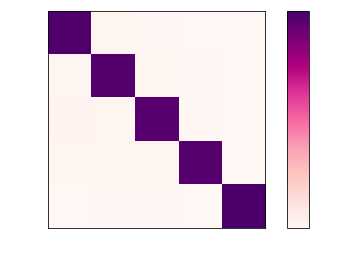

In [7]:
# result=explain.ShowResult(tot_labels, tot_pred_labels)
# cm_mat = result.show_result()
ticks = np.linspace(0, 1, 11)
# cm = np.array([[1043, 341, 125, 255, 161],
#                 [666, 910, 130, 195, 140],
#                 [712, 536, 624, 173, 183],
#                 [187, 174, 39, 438, 288],
#                 [6, 10, 12, 28, 427]])
cm = cm_mat.values[0:5,0:5]
cm[[0, 2]] = cm[[2, 0]]
cm[:,[0, 2]] = cm[:,[2, 0]]
# cm[[0, 2]] = cm[[2, 0]]

# print(cm)
# print(cm.shape)
# print(cm_mat.values)
sum = np.sum(cm, axis=1).reshape(5, 1)
# print(sum)
# print(sum.shape)
cm = cm/sum
# print(cm)
fig = plt.figure()
ax = plt.gca()
im = ax.imshow(cm, vmin=0, vmax=1, cmap='RdPu')
ax.set_xlabel('Predicted label', color='white')
ax.set_ylabel('True label', color='white')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticklabels(['1++', '1++', '1+', '1', '2', '3'])
ax.set_yticklabels(['1++', '1++', '1+', '1', '2', '3'])
ax.tick_params(axis='both', which='both', length=0, color='white')
plt.setp(ax.get_xticklabels(), color="white")
plt.setp(ax.get_yticklabels(), color="white")




divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.3)
cb = plt.colorbar(im, cax=cax, ticks=ticks, )

cb.set_label('Accuracy', color='white')

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color='white')

# set colorbar edgecolor 
# cb.outline.set_edgecolor('white')

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_yticklabels(), visible=False)
plt.show()

In [8]:
# Model: ResNeXt50_32x4d
# model=models.resnet50(pretrained=False)
# model = models.mobilenet_v3_small(pretrained=False)
# 최종 Label 의 개수 = 5 (1++, 1+, 1, 2, 3)
# model.fc=nn.Linear(model.fc.in_features, 5)

# model_names= sorted(name for name in models.__dict__
#                    if name.islower() and not name.startswith("__")
#                     and callable(models.__dict__[name]))
model_names = ['vgg19', 'resnext50_32x4d', 'mobilenet_v3_small']
ckpt_names = ['vgg19_trial_1_best_Acc', 'resnext50_32x4d_trial1_best_Acc',
              'mobilenet_v3_small_trial_1_best_Acc', 'mobilenet_v3_small_transfer_best_Acc']
# 0 for vgg
# 1 for resnext50
# 2 for mobilenet
model_name = model_names[2] # choose resnext
ckpt_name = ckpt_names[2]

model=models.__dict__[model_name](pretrained=False)

if 'res' in str(model_name):
        model.fc=nn.Linear(model.fc.in_features, 5)
    
elif 'vgg' in str(model_name):
    model.classifier[-4]=nn.Linear(in_features=4096, out_features=256)
    model.classifier[-1]=nn.Linear(in_features=256, out_features=5)

elif 'mobilenet' in str(model_name):
    model.classifier[0] = nn.Linear(in_features=model.classifier[0].in_features, out_features=256)
    model.classifier[3] = nn.Linear(in_features=256, out_features=5)

# 학습된 모델 가중치 불러오기
checkpoint=torch.load(ckpt_dir + ckpt_name + '.pth', map_location=device)
model.load_state_dict(checkpoint['state_dict'])

now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 시작 시간 : {nowDatetime}')

since=time.time()

tot_labels=[]  # 전체 정답 Label 을 저장할 리스트
tot_pred_labels=[]  # 전체 예측 Label 을 저장할 리스트

# 모델을 device에 올림
model=model.to(device)
# 네트워크를 evaluation 용으로 선언
model=model.eval()

# test 이기 때문에 backprop 진행 x
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):

        images=images.to(device)
        labels=labels.to(device)

        # Model Prediction (forward)
        output=model(images).detach().cpu()
        _, output_index = torch.max(output, 1)    

        tot_labels.extend(list(labels.detach().cpu().numpy()))
        tot_pred_labels.extend(list(output_index.view(-1).numpy()))

end=time.time()
print(f'테스트 소요 시간: {int((end-since)//60)}m {int((end-since)%60)}s')
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 종료 시간 : {nowDatetime}')

result=explain.ShowResult(tot_labels, tot_pred_labels)
cm_mat = result.show_result()


테스트 시작 시간 : 2021-12-12 16:08:30


100%|██████████| 61/61 [01:25<00:00,  1.40s/it]

테스트 소요 시간: 1m 25s
테스트 종료 시간 : 2021-12-12 16:09:56
#-- Final Average Accuracy
( 98.052 + 98.193 + 98.193 + 99.052 + 99.923 ) / 5 = 98.683


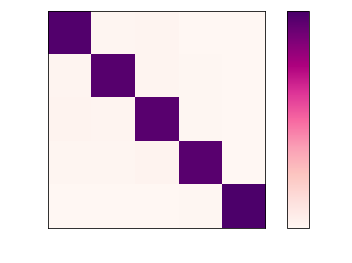

In [9]:
# result=explain.ShowResult(tot_labels, tot_pred_labels)
# cm_mat = result.show_result()
ticks = np.linspace(0, 1, 11)
# cm = np.array([[1043, 341, 125, 255, 161],
#                 [666, 910, 130, 195, 140],
#                 [712, 536, 624, 173, 183],
#                 [187, 174, 39, 438, 288],
#                 [6, 10, 12, 28, 427]])
cm = cm_mat.values[0:5,0:5]
cm[[0, 2]] = cm[[2, 0]]
cm[:,[0, 2]] = cm[:,[2, 0]]
# cm[[0, 2]] = cm[[2, 0]]

# print(cm)
# print(cm.shape)
# print(cm_mat.values)
sum = np.sum(cm, axis=1).reshape(5, 1)
# print(sum)
# print(sum.shape)
cm = cm/sum
# print(cm)
fig = plt.figure()
ax = plt.gca()
im = ax.imshow(cm, vmin=0, vmax=1, cmap='RdPu')
ax.set_xlabel('Predicted label', color='white')
ax.set_ylabel('True label', color='white')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticklabels(['1++', '1++', '1+', '1', '2', '3'])
ax.set_yticklabels(['1++', '1++', '1+', '1', '2', '3'])
ax.tick_params(axis='both', which='both', length=0, color='white')
plt.setp(ax.get_xticklabels(), color="white")
plt.setp(ax.get_yticklabels(), color="white")




divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.3)
cb = plt.colorbar(im, cax=cax, ticks=ticks, )

cb.set_label('Accuracy', color='white')

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color='white')

# set colorbar edgecolor 
# cb.outline.set_edgecolor('white')

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_yticklabels(), visible=False)
plt.show()

In [10]:
# Model: ResNeXt50_32x4d
# model=models.resnet50(pretrained=False)
# model = models.mobilenet_v3_small(pretrained=False)
# 최종 Label 의 개수 = 5 (1++, 1+, 1, 2, 3)
# model.fc=nn.Linear(model.fc.in_features, 5)

# model_names= sorted(name for name in models.__dict__
#                    if name.islower() and not name.startswith("__")
#                     and callable(models.__dict__[name]))
model_names = ['vgg19', 'resnext50_32x4d', 'mobilenet_v3_small']
ckpt_names = ['vgg19_trial_1_best_Acc', 'resnext50_32x4d_trial1_best_Acc',
              'mobilenet_v3_small_trial_1_best_Acc', 'mobilenet_v3_small_transfer_best_Acc']
# 0 for vgg
# 1 for resnext50
# 2 for mobilenet
model_name = model_names[2] # choose resnext
ckpt_name = ckpt_names[3]

model=models.__dict__[model_name](pretrained=False)

if 'res' in str(model_name):
        model.fc=nn.Linear(model.fc.in_features, 5)
    
elif 'vgg' in str(model_name):
    model.classifier[-4]=nn.Linear(in_features=4096, out_features=256)
    model.classifier[-1]=nn.Linear(in_features=256, out_features=5)

elif 'mobilenet' in str(model_name):
    model.classifier[0] = nn.Linear(in_features=model.classifier[0].in_features, out_features=256)
    model.classifier[3] = nn.Linear(in_features=256, out_features=5)

# 학습된 모델 가중치 불러오기
checkpoint=torch.load(ckpt_dir + ckpt_name + '.pth', map_location=device)
model.load_state_dict(checkpoint['state_dict'])

now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 시작 시간 : {nowDatetime}')

since=time.time()

tot_labels=[]  # 전체 정답 Label 을 저장할 리스트
tot_pred_labels=[]  # 전체 예측 Label 을 저장할 리스트

# 모델을 device에 올림
model=model.to(device)
# 네트워크를 evaluation 용으로 선언
model=model.eval()

# test 이기 때문에 backprop 진행 x
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):

        images=images.to(device)
        labels=labels.to(device)

        # Model Prediction (forward)
        output=model(images).detach().cpu()
        _, output_index = torch.max(output, 1)    

        tot_labels.extend(list(labels.detach().cpu().numpy()))
        tot_pred_labels.extend(list(output_index.view(-1).numpy()))

end=time.time()
print(f'테스트 소요 시간: {int((end-since)//60)}m {int((end-since)%60)}s')
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 종료 시간 : {nowDatetime}')

result=explain.ShowResult(tot_labels, tot_pred_labels)
cm_mat = result.show_result()


테스트 시작 시간 : 2021-12-12 16:09:57


100%|██████████| 61/61 [01:25<00:00,  1.40s/it]

테스트 소요 시간: 1m 25s
테스트 종료 시간 : 2021-12-12 16:11:22
#-- Final Average Accuracy
( 68.128 + 67.923 + 68.384 + 86.159 + 95.297 ) / 5 = 77.178


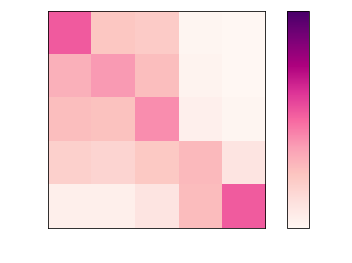

In [11]:
# result=explain.ShowResult(tot_labels, tot_pred_labels)
# cm_mat = result.show_result()
ticks = np.linspace(0, 1, 11)
# cm = np.array([[1043, 341, 125, 255, 161],
#                 [666, 910, 130, 195, 140],
#                 [712, 536, 624, 173, 183],
#                 [187, 174, 39, 438, 288],
#                 [6, 10, 12, 28, 427]])
cm = cm_mat.values[0:5,0:5]
cm[[0, 2]] = cm[[2, 0]]
cm[:,[0, 2]] = cm[:,[2, 0]]
# cm[[0, 2]] = cm[[2, 0]]

# print(cm)
# print(cm.shape)
# print(cm_mat.values)
sum = np.sum(cm, axis=1).reshape(5, 1)
# print(sum)
# print(sum.shape)
cm = cm/sum
# print(cm)
fig = plt.figure()
ax = plt.gca()
im = ax.imshow(cm, vmin=0, vmax=1, cmap='RdPu')
ax.set_xlabel('Predicted label', color='white')
ax.set_ylabel('True label', color='white')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticklabels(['1++', '1++', '1+', '1', '2', '3'])
ax.set_yticklabels(['1++', '1++', '1+', '1', '2', '3'])
ax.tick_params(axis='both', which='both', length=0, color='white')
plt.setp(ax.get_xticklabels(), color="white")
plt.setp(ax.get_yticklabels(), color="white")




divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.3)
cb = plt.colorbar(im, cax=cax, ticks=ticks, )

cb.set_label('Accuracy', color='white')

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color='white')

# set colorbar edgecolor 
# cb.outline.set_edgecolor('white')

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_yticklabels(), visible=False)
plt.show()

## Accuracy